In [1]:
from utils import set_plot_style

selected_colors = set_plot_style()

In [2]:
import pandas as pd

# Replace 'path_to_csv' with the actual path to your CSV file
file_path = "Data/metadata_for_preprocessed_files.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to ensure it's loaded correctly
print(data.head())

   Unnamed: 0             ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV  \
0           0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743   
1           0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743   
2           0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743   
3           0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743   
4           0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743   

     ASF  Delay                                               path  \
0  1.306    NaN  Data/OASIS_Extracted/OAS1_0001/OAS1_0001_MR1_m...   
1  1.306    NaN  Data/OASIS_Extracted/OAS1_0001/OAS1_0001_MR1_m...   
2  1.306    NaN  Data/OASIS_Extracted/OAS1_0001/OAS1_0001_MR1_m...   
3  1.306    NaN  Data/OASIS_Extracted/OAS1_0001/OAS1_0001_MR1_m...   
4  1.306    NaN  Data/OASIS_Extracted/OAS1_0001/OAS1_0001_MR1_m...   

   slice_number  is_masked  
0            63       True  
1           151      False  
2    

In [3]:
# Check basic information about the DataFrame
print(data.info())

# Check for missing values in the 'CDR' column
print(f'Number of Null entries: {data["CDR"].isnull().sum()}')

# Get unique values in 'CDR' column to understand the distribution
print(f'Different values for CDR: {data["CDR"].unique()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153472 entries, 0 to 153471
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    153472 non-null  int64  
 1   ID            153472 non-null  object 
 2   M/F           153472 non-null  object 
 3   Hand          153472 non-null  object 
 4   Age           153472 non-null  int64  
 5   Educ          82720 non-null   float64
 6   SES           76032 non-null   float64
 7   MMSE          82720 non-null   float64
 8   CDR           153472 non-null  float64
 9   eTIV          153472 non-null  int64  
 10  nWBV          153472 non-null  float64
 11  ASF           153472 non-null  float64
 12  Delay         7040 non-null    float64
 13  path          153472 non-null  object 
 14  slice_number  153472 non-null  int64  
 15  is_masked     153472 non-null  bool   
dtypes: bool(1), float64(7), int64(4), object(4)
memory usage: 17.7+ MB
None
Number of Null entri

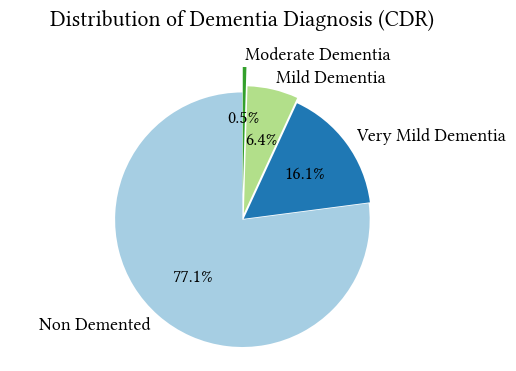

In [4]:
import matplotlib.pyplot as plt

# Mapping CDR scores to descriptive labels
cdr_labels = {
    0.0: "Non Demented",
    0.5: "Very Mild Dementia",
    1.0: "Mild Dementia",
    2.0: "Moderate Dementia",
}
data["Dementia Status"] = data["CDR"].map(cdr_labels)

# Preparing data for plotting
plot_data = data["Dementia Status"].value_counts()

# Configuring the pie chart to avoid label overlap
explode = (0, 0.0125, 0.05, 0.2)  # Only explode the first slice if it's the smallest
plt.figure(figsize=(6, 4))
plt.pie(
    plot_data,
    labels=plot_data.index,
    autopct="%1.1f%%",
    startangle=90,
    explode=explode,
    textprops={"fontsize": 13},
)
plt.title("Distribution of Dementia Diagnosis (CDR)", pad=20)
plt.axis("equal")

# Adding a legend
# plt.legend(plot_data.index, title="Dementia Status", title_fontsize='13', fontsize='12', loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig("plots/class_distribution.pdf", format="pdf", bbox_inches="tight")


# Show the plot
plt.show()

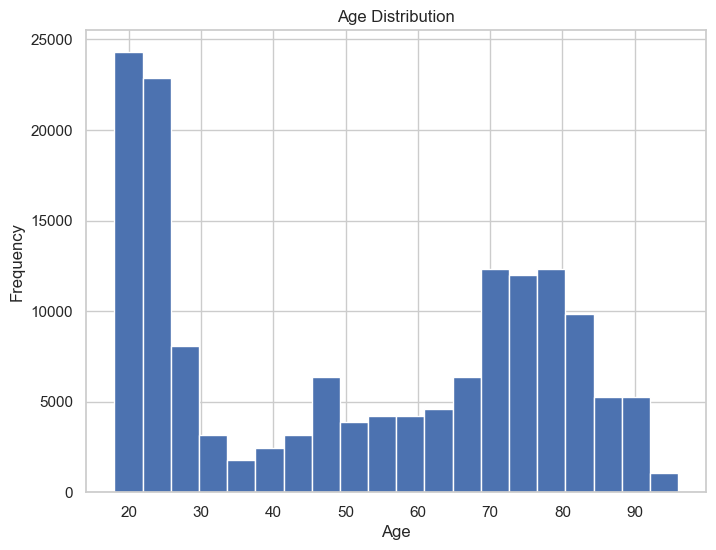

In [66]:
# Histogram for Age
plt.figure(figsize=(8, 6))
plt.hist(data["Age"], bins=20)  # Adjust bins as necessary
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.savefig("plots/distribution_of_ages.pdf", format="pdf", bbox_inches="tight")
plt.show()

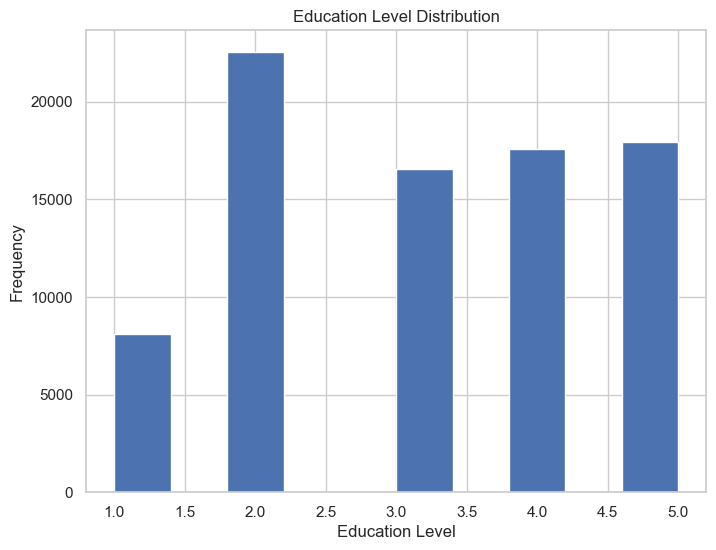

In [67]:
# Histogram for Education Level
plt.figure(figsize=(8, 6))
plt.hist(data["Educ"], bins=10)  # Adjust bins as necessary
plt.title("Education Level Distribution")
plt.xlabel("Education Level")
plt.ylabel("Frequency")
plt.show()

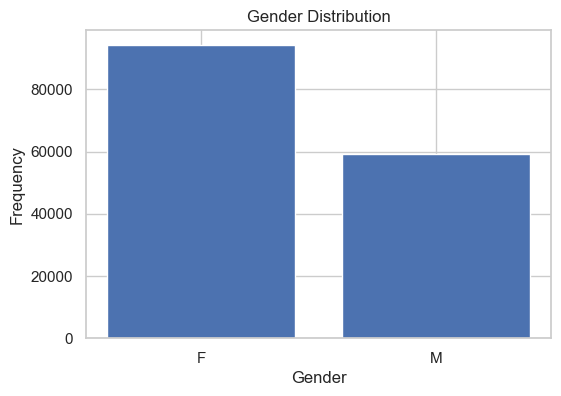

In [68]:
# Bar Chart for Gender Distribution
gender_counts = data["M/F"].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(gender_counts.index, gender_counts)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Frequency")
plt.savefig("plots/distribution_of_genders.pdf", format="pdf", bbox_inches="tight")
plt.show()

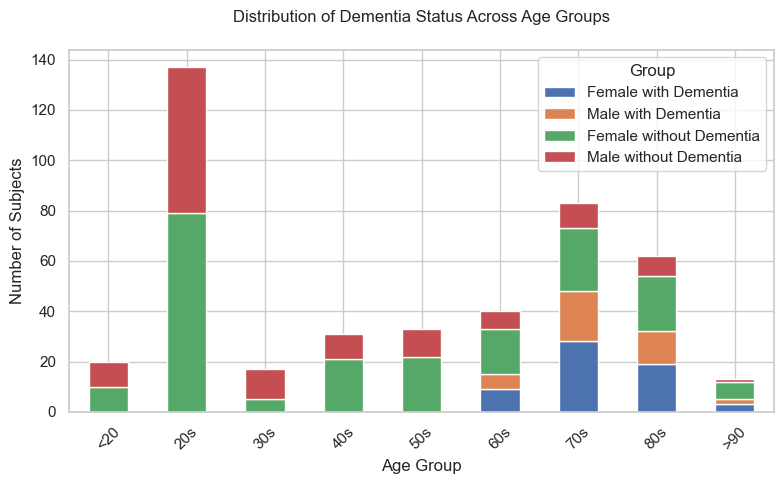

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'data' is loaded and includes 'ID', 'CDR', 'Age', 'M/F' columns
# Mapping CDR to Dementia Status
cdr_labels = {
    0.0: "Non Demented",
    0.5: "Very Mild Dementia",
    1.0: "Mild Dementia",
    2.0: "Moderate Dementia",
}
data["Dementia Status"] = data["CDR"].map(cdr_labels)

# Removing duplicates
data = data.drop_duplicates(subset=["ID", "Age", "M/F", "Dementia Status"])

# Bin ages
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, np.inf]
labels = ["<20", "20s", "30s", "40s", "50s", "60s", "70s", "80s", ">90"]
data["Age Group"] = pd.cut(data["Age"], bins=bins, labels=labels, right=False)

# Preparing data for stacked bar chart
plot_data = (
    data.groupby(["Age Group", "M/F", "Dementia Status"]).size().unstack(fill_value=0)
)

# Sum up the dementia statuses for males and females
plot_data = plot_data.groupby(["Age Group", "M/F"]).sum()

# Separate the data by gender and condition
female_dementia = plot_data.xs("F", level="M/F")[
    ["Very Mild Dementia", "Mild Dementia", "Moderate Dementia"]
].sum(axis=1)
male_dementia = plot_data.xs("M", level="M/F")[
    ["Very Mild Dementia", "Mild Dementia", "Moderate Dementia"]
].sum(axis=1)
female_nondementia = plot_data.xs("F", level="M/F")["Non Demented"]
male_nondementia = plot_data.xs("M", level="M/F")["Non Demented"]

# Stack the data for plotting
final_plot_data = pd.DataFrame(
    {
        "Female with Dementia": female_dementia,
        "Male with Dementia": male_dementia,
        "Female without Dementia": female_nondementia,
        "Male without Dementia": male_nondementia,
    }
)

# Creating the plot
fig, ax = plt.subplots(figsize=(8, 5))
final_plot_data.plot(kind="bar", stacked=True, ax=ax)

ax.set_title("Distribution of Dementia Status Across Age Groups", pad=20)
ax.set_xlabel("Age Group")
ax.set_ylabel("Number of Subjects")
ax.legend(title="Group")

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(
    "plots/distribution_of_AL_across_age_groups.pdf", format="pdf", bbox_inches="tight"
)

plt.show()

/var/folders/l5/4bf7qdjd6k9b38g7jlnrcf580000gn/T/ipykernel_92416/720632755.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[2], x='M/F', y='CDR', data=data_without_nans, palette=[selected_colors[1]])
/var/folders/l5/4bf7qdjd6k9b38g7jlnrcf580000gn/T/ipykernel_92416/720632755.py:38: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(ax=axes[2], x='M/F', y='CDR', data=data_without_nans, palette=[selected_colors[1]])


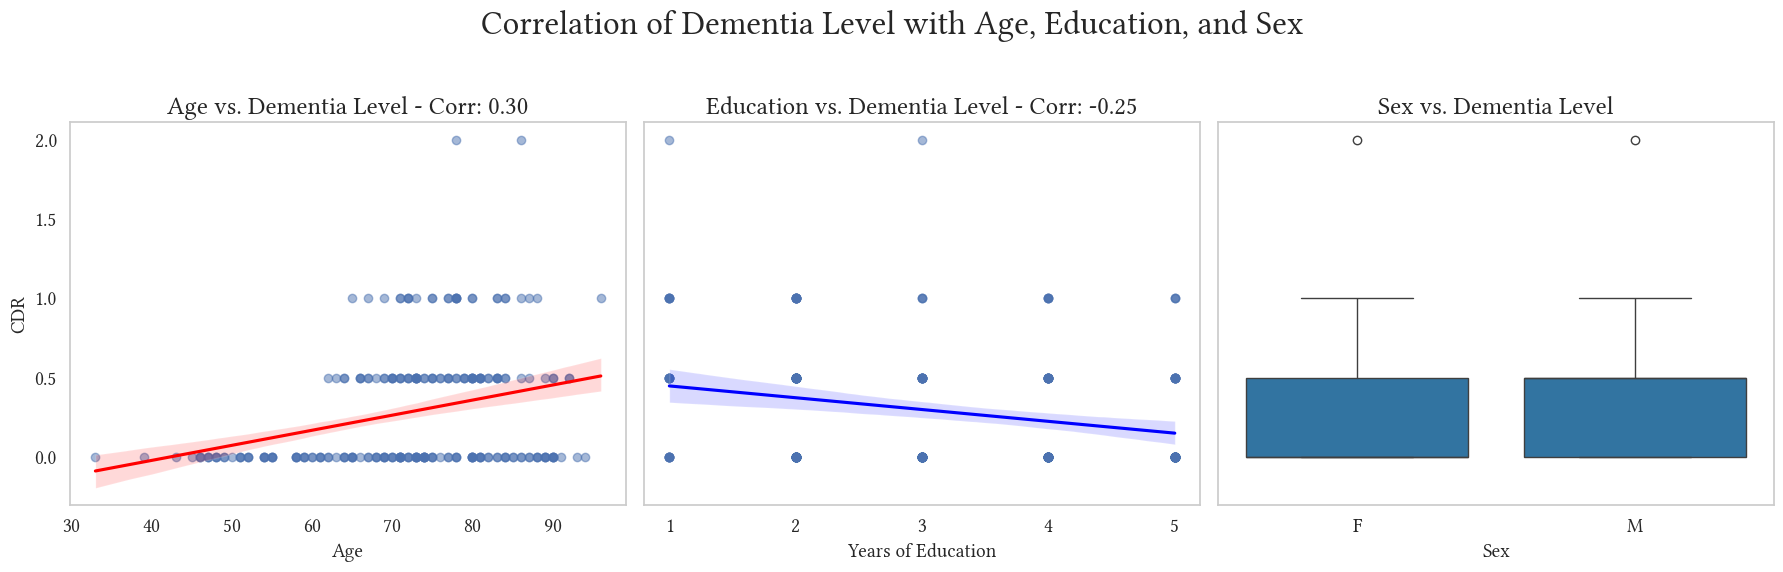

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator

# Define the selected colors
paired_colors = plt.cm.Paired(range(10))
selected_colors = paired_colors[:4]

# Drop rows with NaN values in these columns
data_without_nans = data.dropna(subset=["Age", "Educ", "CDR", "M/F"])

# Calculate correlations
corr_age_cdr = data_without_nans["Age"].corr(data_without_nans["CDR"])
corr_educ_cdr = data_without_nans["Educ"].corr(data_without_nans["CDR"])

# Setting the plot style
sns.set_theme(style="whitegrid")

# Creating a figure to hold the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle(
    "Correlation of Dementia Level with Age, Education, and Sex",
    fontsize=24,
    fontfamily="Libertinus Serif",
)

# Plot 1: Age vs. Dementia Level
sns.regplot(
    ax=axes[0],
    x="Age",
    y="CDR",
    data=data_without_nans,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "red"},
)
axes[0].set_title(
    f"Age vs. Dementia Level - Corr: {corr_age_cdr:.2f}",
    fontfamily="Libertinus Serif",
    fontsize=18,
)
axes[0].set_xlabel("Age", fontfamily="Libertinus Serif", fontsize=14)
axes[0].set_ylabel("CDR", fontfamily="Libertinus Serif", fontsize=14)

# Plot 2: Education vs. Dementia Level
sns.regplot(
    ax=axes[1],
    x="Educ",
    y="CDR",
    data=data_without_nans,
    scatter_kws={"alpha": 0.5},
    line_kws={"color": "blue"},
)
axes[1].set_title(
    f"Education vs. Dementia Level - Corr: {corr_educ_cdr:.2f}",
    fontfamily="Libertinus Serif",
    fontsize=18,
)
axes[1].set_xlabel("Years of Education", fontfamily="Libertinus Serif", fontsize=14)
axes[1].set_ylabel(
    "CDR", fontfamily="Libertinus Serif", fontsize=14
)  # Corrected placement of y-label

# Plot 3: Sex vs. Dementia Level with custom color
sns.boxplot(
    ax=axes[2], x="M/F", y="CDR", data=data_without_nans, palette=[selected_colors[1]]
)
axes[2].set_title("Sex vs. Dementia Level", fontfamily="Libertinus Serif", fontsize=18)
axes[2].set_xlabel("Sex", fontfamily="Libertinus Serif", fontsize=14)
axes[2].set_ylabel("CDR", fontfamily="Libertinus Serif", fontsize=14)  # Added y-label

# Correct the Y-label settings for the second and third plots
axes[1].set_ylabel("")  # Removes y-label from the second plot
axes[2].set_ylabel("")  # Removes y-label from the third plot

# Apply font settings explicitly to ticks after seaborn has been configured
for ax in axes:
    ax.grid(False)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname("Libertinus Serif")
        label.set_fontsize(14)  # You can adjust the size as needed

axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout(
    rect=[0, 0.03, 1, 0.95]
)  # Adjust the subplots to give some space for the main title

# Save the plot as a tightly bounded PDF
plt.savefig(
    "plots/correlation_of_dementia_with_age_education_sex.pdf",
    format="pdf",
    bbox_inches="tight",
)

plt.show()